Importando base de coordenadas CENSO 2022

In [1]:
import basedosdados as bd
import pandas as pd

In [2]:

query_cord = """
    SELECT *
    FROM `basedosdados.br_ibge_censo_2022.coordenada_endereco` 
    WHERE id_municipio IN ('1506807')
"""
df_coord = bd.read_sql(query_cord,
billing_project_id="extended-spark-302513")

Downloading: 100%|██████████| 146496/146496 [00:16<00:00, 9003.60rows/s]


In [2]:
df_coord

NameError: name 'df_coord' is not defined

Importando a base de diconario

In [ ]:
query_dict = """
    SELECT *
    FROM `basedosdados.br_ibge_censo_2022.dicionario`
"""
     = bd.read_sql(query_dict, 
billing_project_id="extended-spark-302513")



Downloading: 100%|██████████| 14/14 [00:00<00:00, 37.37rows/s]


In [ ]:
len(df_dict)

14

In [ ]:
values = df_dict['valor']
values

0                                  Domicílio particular
1                 Estabelecimento de outras finalidades
2                              Estabelecimento de saúde
3                                    Domicílio coletivo
4                          Estabelecimento agropecuário
5                              Edificação em construção
6                             Estabelecimento de ensino
7                             Estabelecimento religioso
8                                        Face de quadra
9          Endereço - coordenada original do Censo 2022
10                                     Setor censitário
11    Endereço - coordenada modificada (apartamentos...
12    Endereço - coordenada estimada (endereços orig...
13                                           Localidade
Name: valor, dtype: object

In [3]:
df_filtrado = df_coord[df_coord['especie_endereco'].isin(['6', '7'])]
df_filtrado

,id_uf,id_municipio,especie_endereco,nivel_geo_coordenada,latitude,longitude,ponto
121834,15,1506807,6,1,-2.434646,-54.718752,POINT(-54.718752 -2.434646)
121835,15,1506807,6,1,-2.437311,-54.718883,POINT(-54.718883 -2.437311)
121836,15,1506807,6,1,-2.437122,-54.719201,POINT(-54.719201 -2.437122)
121837,15,1506807,6,1,-2.443552,-54.722976,POINT(-54.722976 -2.443552)
121838,15,1506807,6,1,-2.444455,-54.727242,POINT(-54.727242 -2.444455)
...,...,...,...,...,...,...,...
145481,15,1506807,7,1,-2.272061,-55.261873,POINT(-55.261873 -2.272061)
145482,15,1506807,7,1,-2.271798,-55.155474,POINT(-55.155474 -2.271798)
145483,15,1506807,7,1,-2.315628,-55.544450,POINT(-55.54445 -2.315628)
145484,15,1506807,7,1,-2.362593,-55.645747,POINT(-55.645747 -2.362593)


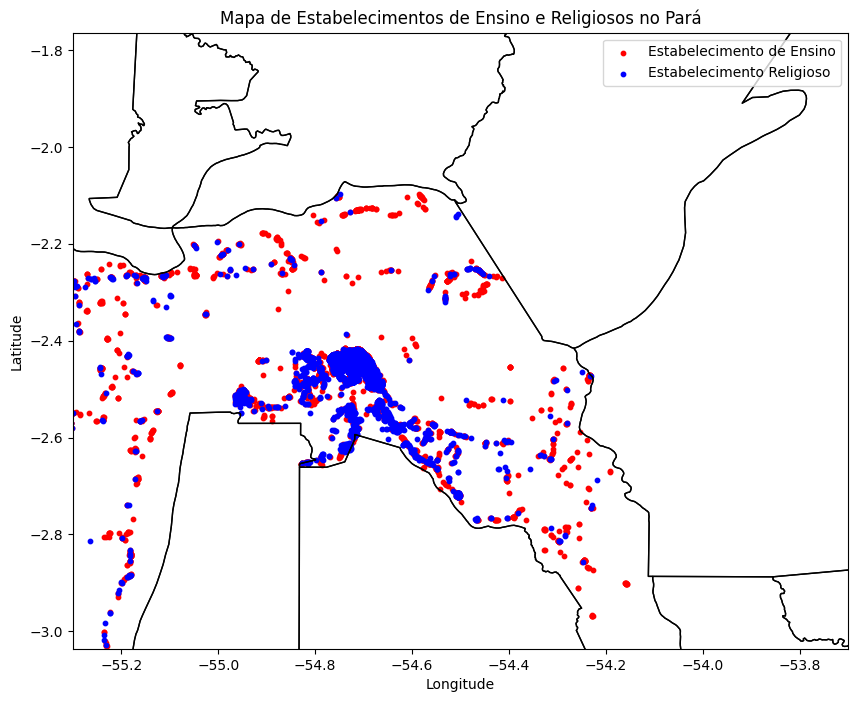

In [22]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

# Crie um GeoDataFrame para representar algumas ruas (exemplo simplificado)
data = {'geometry': [LineString([(0, 0), (0, 1)]), LineString([(1, 0), (1, 1)])]}
gdf_ruas = gpd.GeoDataFrame(data, geometry='geometry')

# Crie um GeoDataFrame a partir do DataFrame existente
geometry = [Point(xy) for xy in zip(df_coord['longitude'], df_coord['latitude'])]
gdf = gpd.GeoDataFrame(df_coord, geometry=geometry)

# Carregar o shapefile dos limites municipais do Pará
limites_para = gpd.read_file('PA_Municipios_2022.shx')  # Substitua pelo caminho real do seu shapefile

# Filtrar o GeoDataFrame para valores 6 e 7
gdf_ensino = gdf[gdf['especie_endereco'].isin(['6', '7'])]

# Plotar o GeoDataFrame e os limites do estado do Pará
fig, ax = plt.subplots(figsize=(10, 8))

# Plotar as ruas
gdf_ruas.plot(ax=ax, color='grey', linewidth=1, alpha=0.5)

# Plotar os pontos para estabelecimentos de ensino e religiosos
gdf_ensino[gdf_ensino['especie_endereco'] == '6'].plot(ax=ax, color='red', label='Estabelecimento de Ensino', markersize=10)
gdf_ensino[gdf_ensino['especie_endereco'] == '7'].plot(ax=ax, color='blue', label='Estabelecimento Religioso', markersize=10)

# Plotar os limites do estado do Pará
limites_para.plot(ax=ax, color='none', edgecolor='black')

# Adicionar rótulos e legendas
plt.title('Mapa de Estabelecimentos de Ensino e Religiosos no Pará')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Ajustar o aspecto da figura
ax.set_aspect('equal', adjustable='datalim')

# Ajustar os limites para a área de Santarém
ax.set_xlim([-55.3, -53.7])  # Ajuste os valores de acordo com a área desejada
ax.set_ylim([-2.6, -2.2])   # Ajuste os valores de acordo com a área desejada

# Exibir o mapa
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

link = 'https://raw.githubusercontent.com/linolnfrias/dados/master/'
